# P1: Particle Metroplis-Hastings

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Generate data
T = 50
y = np.zeros(T)
x = np.random.normal(loc=0.0, scale=1.0, size=1)
theta = -1

for t in range(T):
    x = np.cos(theta*x) + np.random.normal(loc=0.0, scale=1.0, size=1)
    y[t] = x + np.random.normal(loc=0.0, scale=1.0, size=1)

def gaussian_random_walk(x, sigma=1.0):
    return np.random.normal(x, sigma)

In [63]:
def bootstrap_particle_filter(y, n_particles, theta=1.0):
    
    # Initilialization
    T = len(y)
    logl = 0.0
    x = np.zeros([T+1, n_particles])
    w = np.zeros([T+1, n_particles])
    x[0, :] = np.random.normal(0.0, 1.0, size=n_particles)
    w[0, :] = np.ones(n_particles) / n_particles
    
    for t in range(1, T+1):
        
        a = np.random.choice(n_particles, n_particles, p=w[t-1, :])
        x[t, :] = np.cos(theta*x[t-1, a]) + np.random.normal(loc=0.0, scale=1.0, size=n_particles)
        log_w_tilde = x[t, :] + np.random.normal(loc=0.0, scale=1.0, size=n_particles) 
        log_w_tilde = norm.logpdf(y[t-1], loc=x[t, :], scale=1.0)
        
        # Compute log-liklihood with logsumexp trick
        max_w_tilde = np.max(log_w_tilde)
        log_w_tilde = log_w_tilde - max_w_tilde # subtract with maximum value of log weights
        logl += max_w_tilde + np.log(np.sum(np.exp(log_w_tilde))) - np.log(n_particles)
        
        # normalize weights
        w[t, :] = np.exp(log_w_tilde) / np.sum(np.exp(log_w_tilde))                          
    return x, w, logl


In [77]:
def particle_metropolis_hastings(y, M=10000, N=20):
    
    Z_hat = np.zeros(M)
    theta = np.zeros(M)
    
    theta[0] = np.random.normal(0.0, 1.0)
    _, _, z_hat = bootstrap_particle_filter(y, N, theta[0])
    Z_hat[0] = z_hat

    count = 0
    for m in range(1, M):
        
        # Draw sample from proposal
        theta_sample = gaussian_random_walk(theta[m-1])
        
        # Sample from uniform distribution
        u = np.random.uniform(0.0, 1.0)
        
        # Compute acceptance probability
        _, _, z_hat_sample = bootstrap_particle_filter(y, N, theta_sample)
        
        # Using gaussian random walk as proposal q should cancel out when computing acceptance probability alpha
        p_theta = norm.pdf(theta[m-1], loc=0.0, scale=1.0)
        p_theta_curr = norm.pdf(theta_sample, loc=0.0, scale=1.0)
        q_theta = norm.pdf(theta[m-1], loc=theta_sample, scale=1.0) 
        q_theta_curr = norm.pdf(theta_sample, loc=theta[m-1], scale=1.0) 
        
        # We have to take exponential of z_hat since it's the log-likelihood
        # We could compute logpdf instead of pdf and add the terms, this might be more numerically stable too
        num = np.exp(z_hat_sample) * p_theta_curr * q_theta
        den = np.exp(Z_hat[m-1]) * p_theta * q_theta_curr
        alpha = np.minimum(1.0, num /den)
        
        # Set sampled theta and z_hat as current
        if u <= alpha:
            # Accept sampled theta and log-likelihood z_hat
            theta[m] = theta_sample
            Z_hat[m] = z_hat_sample
            count += 1
        else: 
            theta[m] = theta[m-1]
            Z_hat[m] = Z_hat[m-1]
            
        #print("theta: ", theta[m])
    print("Accepted samples: ", count)
    return theta, Z_hat#Theta, Z_hat

Accepted samples:  720


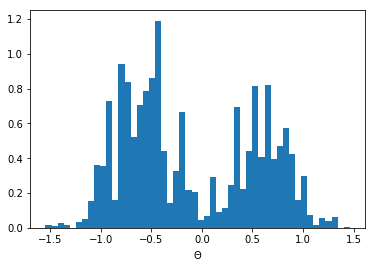

In [74]:
M = 5000
N = 20
Theta, Z_hat = particle_metropolis_hastings(y, M, N)
plt.hist(Theta[1000:], bins=50, density=True)
plt.xlabel("$\Theta$")
plt.show()

## P2: Conditional particle filter